In [1]:
import csv
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
import tensorflow as tf
from keras.regularizers import l1
from sklearn.metrics import auc
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn import preprocessing

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

In [3]:
# load data
train = pd.read_csv('data_train.csv', encoding='unicode_escape')
test=pd.read_csv('data_test.csv', encoding='unicode_escape')

In [4]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=['train'])
NAs[NAs.sum(axis=1) > 0]

,train


In [5]:
#Checking for missing data
NAs = pd.concat([test.isnull().sum()], axis=1, keys=['test'])
NAs[NAs.sum(axis=1) > 0]

,test


<AxesSubplot:>

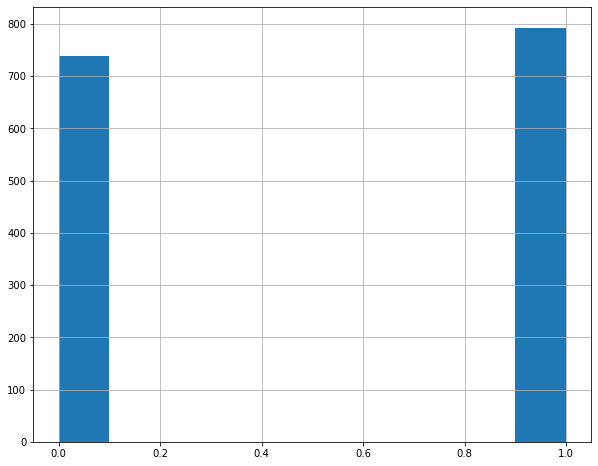

In [6]:
train['GeneXpert'].hist()

<AxesSubplot:>

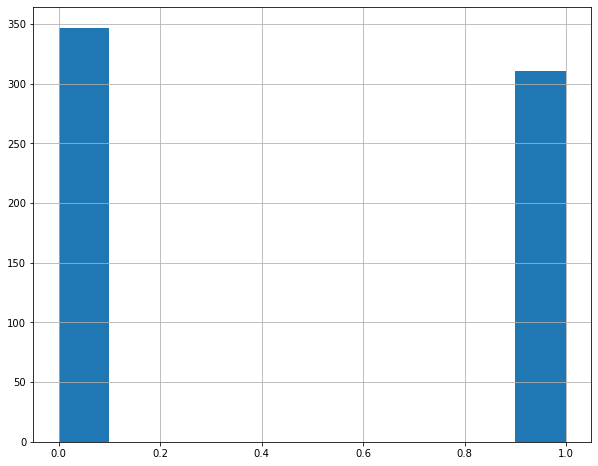

In [7]:
test['GeneXpert'].hist()

In [8]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in ['GeneXpert',]]

In [9]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['GeneXpert'].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['GeneXpert'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Predict training set:
    dtest_predictions = alg.predict(dtest[predictors])
           
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['GeneXpert'], cv=cv_folds, scoring='roc_auc')
     
    #Print model report:
    print("\nModel Report")
    print("Train Accuracy : %.4g" % accuracy_score(dtrain['GeneXpert'].values, dtrain_predictions))
    print("Test Accuracy : %.4g" % accuracy_score(dtest['GeneXpert'].values, dtest_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain['GeneXpert'], dtrain_predprob))
          
           
    #Prediction on tetsing data
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    #results = test.merge(dtest[['predprob']])
    print('AUC Score (Test): %f' % roc_auc_score(dtest['GeneXpert'], dtest_predprob))
    
    train_conf_matrix = confusion_matrix(dtrain['GeneXpert'].values, dtrain_predictions)
    print('Training Confusion Matrix : \n', train_conf_matrix)
    
    sensitivity_train = train_conf_matrix[0,0]/(train_conf_matrix[0,0]+train_conf_matrix[0,1])
    print('Training Sensitivity : ', sensitivity_train)

    specificity_train = train_conf_matrix[1,1]/(train_conf_matrix[1,0]+train_conf_matrix[1,1])
    print('Training Specificity : ', specificity_train)

    test_conf_matrix = confusion_matrix(dtest['GeneXpert'].values, dtest_predictions)
    print('Tetsing Confusion Matrix : \n', test_conf_matrix)
    
    sensitivity_test = test_conf_matrix[0,0]/(test_conf_matrix[0,0]+test_conf_matrix[0,1])
    print('Testing Sensitivity : ', sensitivity_test)

    specificity_test = test_conf_matrix[1,1]/(test_conf_matrix[1,0]+test_conf_matrix[1,1])
    print('Testing Specificity : ', specificity_test)
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(dtrain['GeneXpert'], dtrain_predprob)
    # calculate roc curve
    fpr1, tpr1, thresholds1 = roc_curve(dtest['GeneXpert'], dtest_predprob)
        
    fig, ax = pyplot.subplots()
    ax.plot(fpr, tpr, marker='.', label='Train')
    ax.plot(fpr1, tpr1, marker='.', label='Test')
    ax.legend()
    pyplot.ylabel('AUC')
    pyplot.title('Training and Testing AUC for XGBoost')
    pyplot.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    ##feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    ##feat_imp.plot(kind='bar', title='Feature Importances')
    ##pyplot.ylabel('Feature Importance Score')

C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\wujin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Model Report
Train Accuracy : 0.7368
Test Accuracy : 0.7234
AUC Score (Train): 0.819708
AUC Score (Test): 0.820714
Training Confusion Matrix : 
 [[509 229]
 [174 619]]
Training Sensitivity :  0.6897018970189702
Training Specificity :  0.7805800756620429
Tetsing Confusion Matrix : 
 [[237 110]
 [ 72 239]]
Testing Sensitivity :  0.6829971181556196
Testing Specificity :  0.7684887459807074


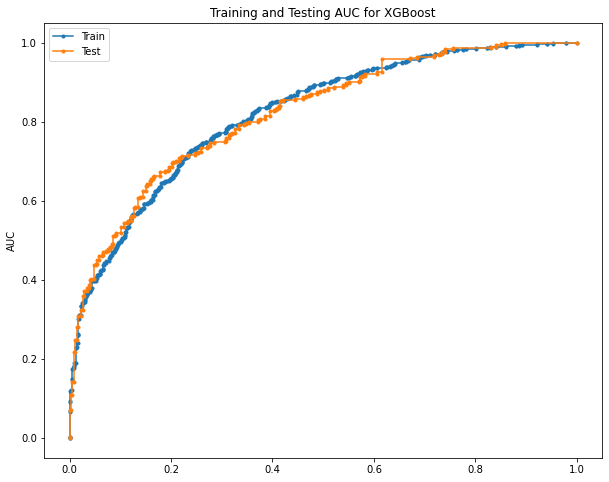

CV Score : Mean - 0.7757353 | Std - 0.02623136 | Min - 0.7230585 | Max - 0.8202703


In [10]:
xgb_best = XGBClassifier(learning_rate =0.03814,
                         n_estimators=2354,
                         max_depth=63,
                         min_child_weight=1,
                         gamma=11,
                         subsample=0.177,
                         colsample_bytree=0.81,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=2)
modelfit(xgb_best, train, test, predictors)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

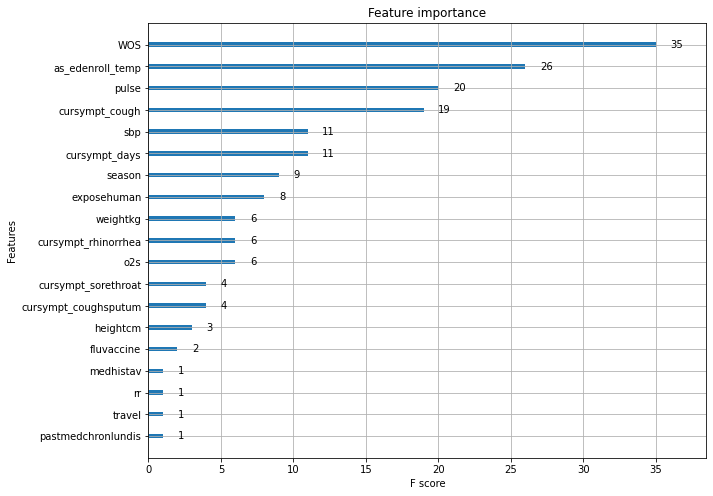

In [11]:
xgb.plot_importance(xgb_best)

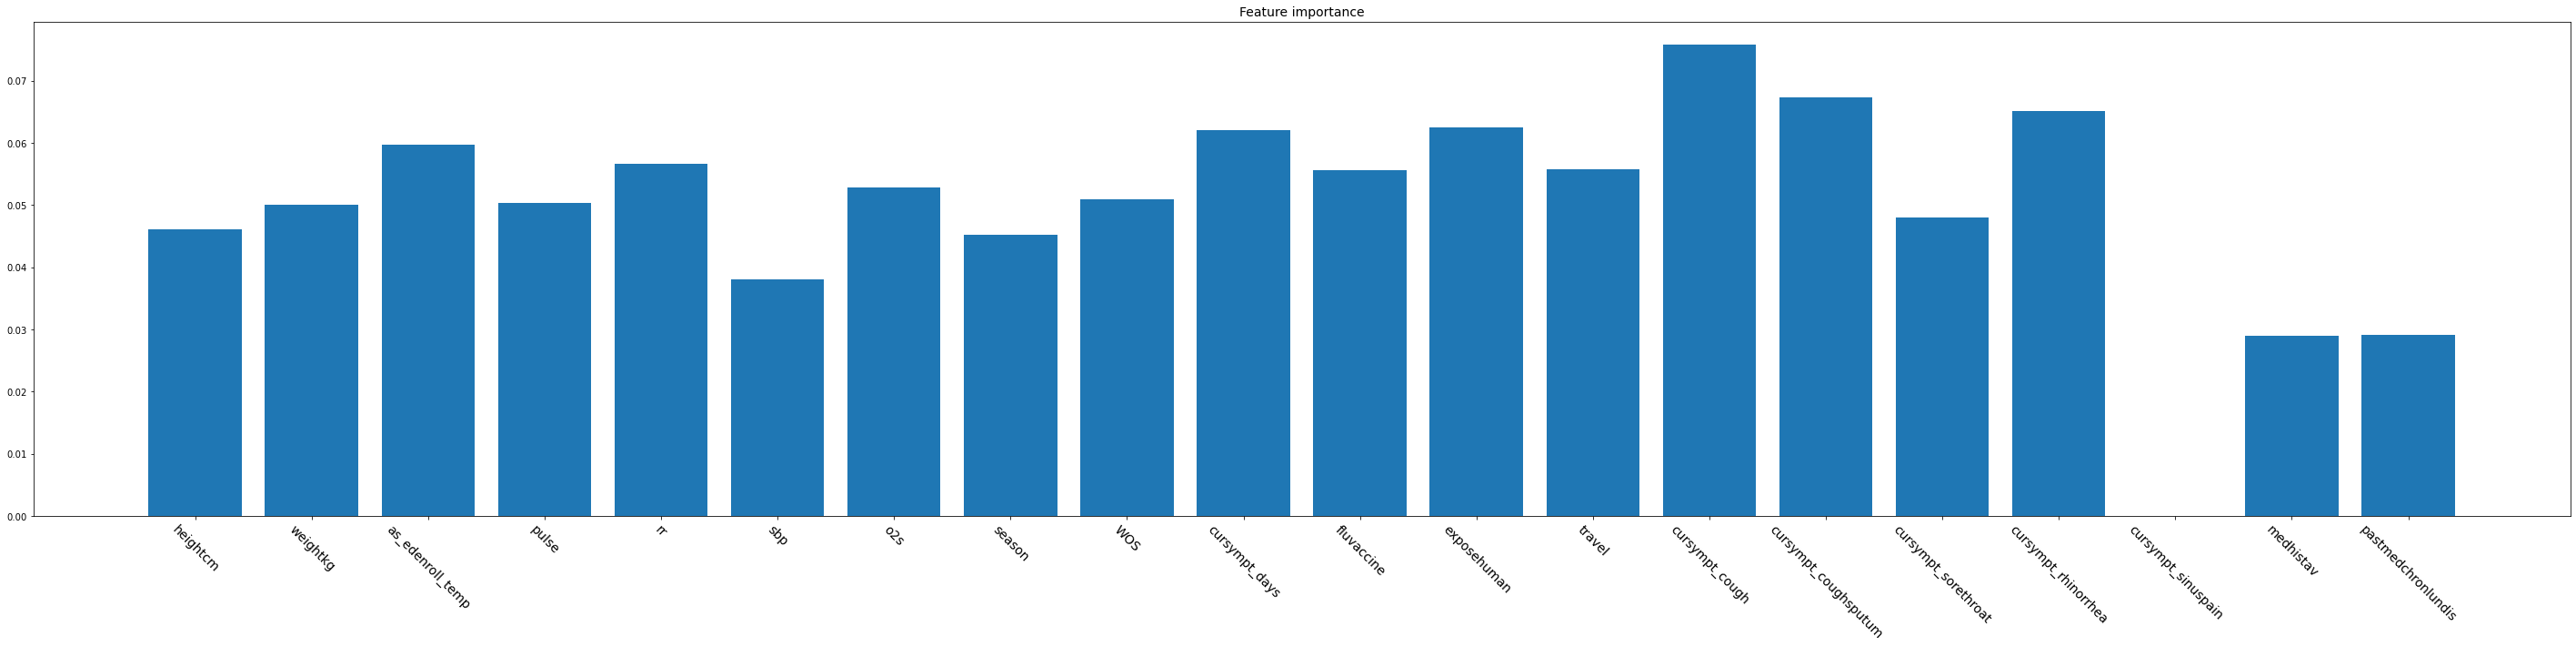

In [12]:
plt.figure(figsize=(50, 10))
plt.bar(range(len(predictors)), xgb_best.feature_importances_)
plt.xticks(range(len(predictors)), predictors, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(1531, 20)


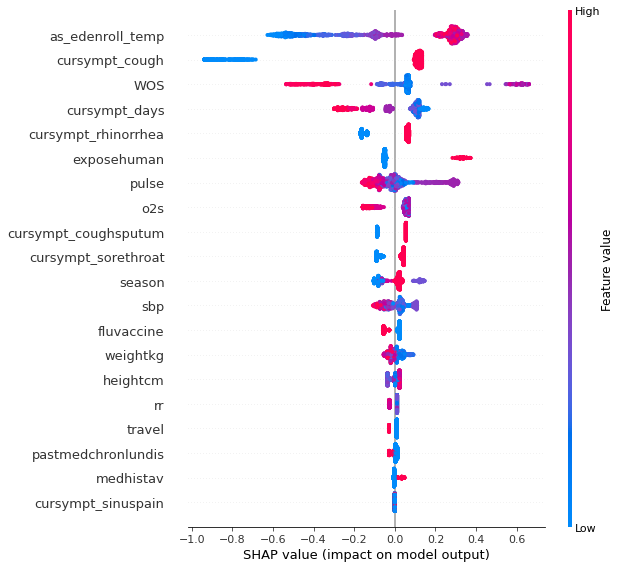

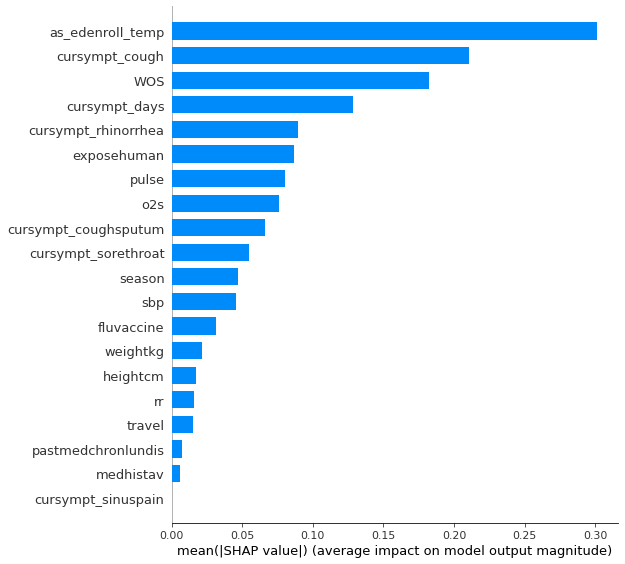

<Figure size 720x576 with 0 Axes>

In [13]:
import shap
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(train[predictors])
print(shap_values.shape)
shap.summary_plot(shap_values, train[predictors])
shap.summary_plot(shap_values, train[predictors], plot_type="bar")
shap.force_plot(explainer.expected_value, shap_values, predictors)
plt.savefig('shape.png', dpi = 400)

In [14]:
train_predprob =pd.DataFrame(xgb_best.predict_proba(train[predictors])[:,1]) 
train_predprob.to_csv("train_predprob.csv",index=False)

In [15]:
test_predprob = pd.DataFrame(xgb_best.predict_proba(test[predictors])[:,1])
test_predprob.to_csv('test_predprob.csv',index=False)

In [16]:
## Probabilistic Calibration
from sklearn.calibration import calibration_curve
xgboost_prediction = xgb_best.predict_proba(test[predictors])
xgb_best.score(test[predictors], test['GeneXpert'])
xgboost_y, xgboost_x = calibration_curve(test['GeneXpert'], xgboost_prediction[:,1], n_bins=25)

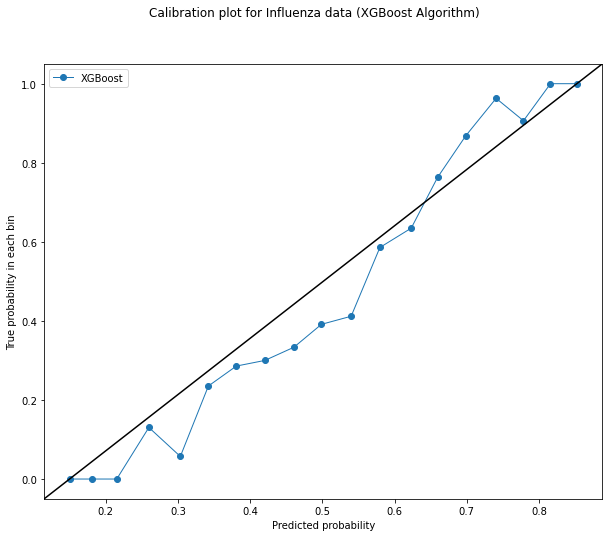

In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgboost_x, xgboost_y, marker='o', linewidth=1, label='XGBoost')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Influenza data (XGBoost Algorithm)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()